In [60]:
import pandas as pd

In [61]:
data = pd.read_csv("bank_credit_data.csv")

In [62]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [63]:
data.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [64]:
data = data.drop(columns= 'Unnamed: 0')
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [65]:
data.shape

(1000, 9)

In [66]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [67]:
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [70]:
data["Job"] = data["Job"].replace([0,1,2,3],["unskilled and non-resident", "unskilled and resident", "skilled", "highly skilled"])

In [71]:
data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,skilled,own,NaN,little,1169,6,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,radio/TV
2,49,male,unskilled and resident,own,little,NaN,2096,12,education
3,45,male,skilled,free,little,little,7882,42,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,unskilled and resident,own,little,NaN,1736,12,furniture/equipment
996,40,male,highly skilled,own,little,little,3857,30,car
997,38,male,skilled,own,little,NaN,804,12,radio/TV
998,23,male,skilled,free,little,little,1845,45,radio/TV


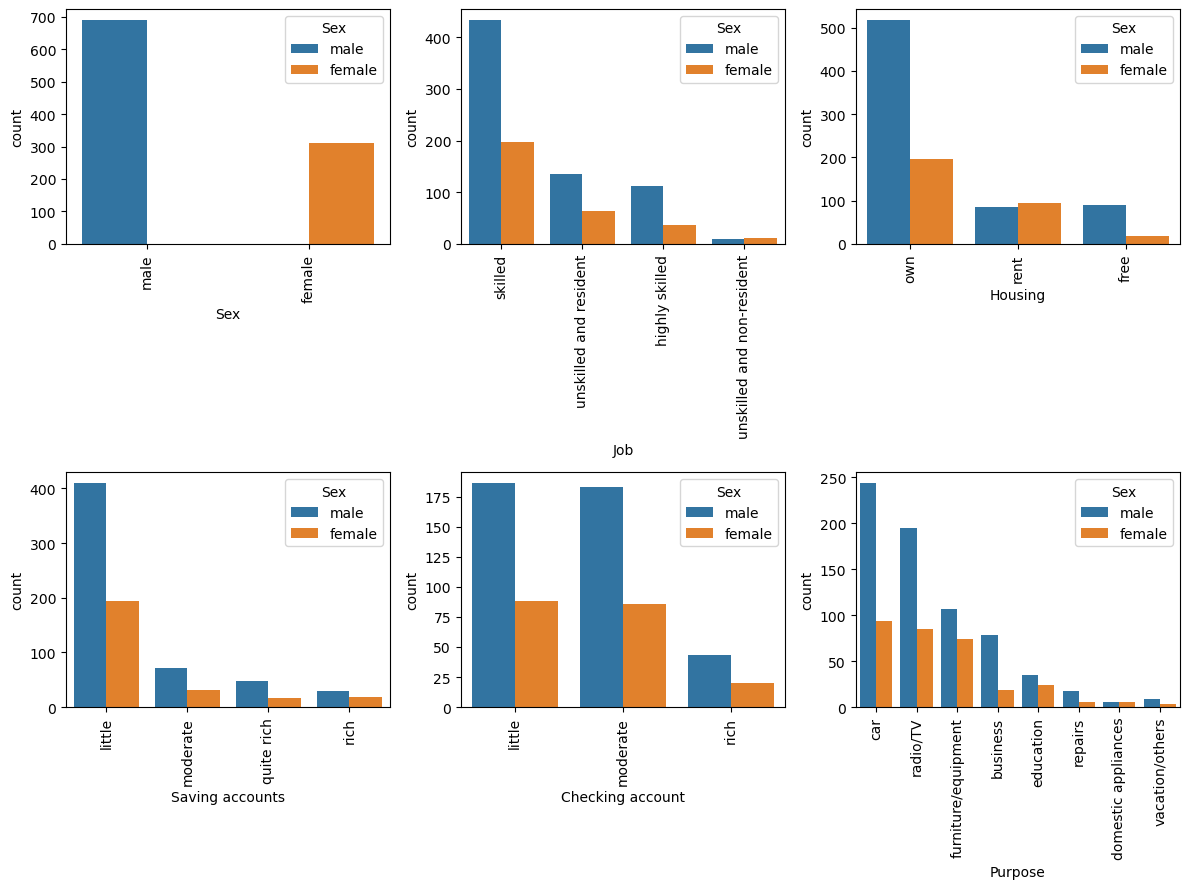

In [72]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

cat_vars = data.select_dtypes('object').columns
ncol = 3
nrow = math.ceil(len(cat_vars)/ncol)
fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(ncol*4, nrow*4.5)
for ax, cat in zip(axes.flatten(), cat_vars):
    sns.countplot(data=data, x=cat, ax=ax, hue='Sex', order=data[cat].value_counts().index)
    ax.tick_params('x', labelrotation=90)
plt.tight_layout()
plt.show()

In [73]:
data.select_dtypes(exclude='object').columns

Index(['Age', 'Credit amount', 'Duration'], dtype='object')

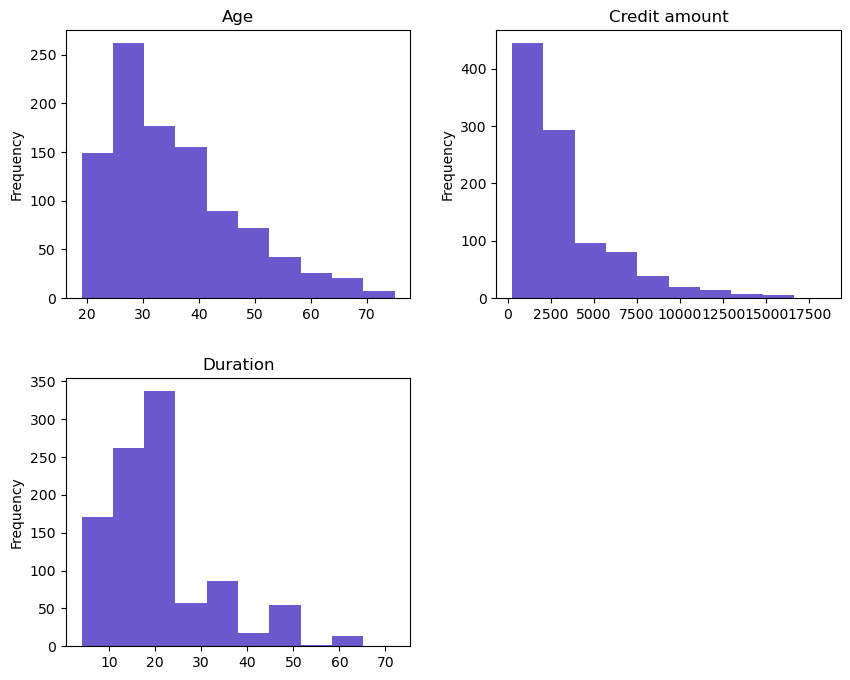

In [74]:
import pyrsm as rsm

rsm.distr_plot(data, ['Age', 'Credit amount', 'Duration'])

We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation. After that let's see how they look like.



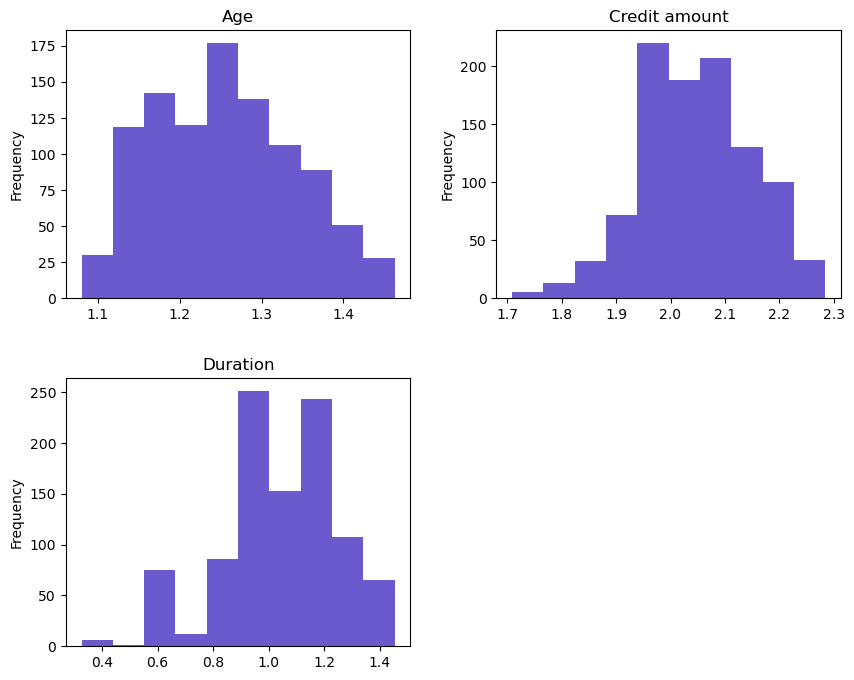

In [58]:
import numpy as np

cluster_log = np.log(data.select_dtypes(exclude='object'))
rsm.distr_plot(cluster_log)
data[["Age","Credit amount", "Duration"]] = cluster_log[["Age","Credit amount", "Duration"]]

In [77]:
def scatter_noticks (x, y, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.tick_params(labelbottom=False, labelleft=False)
    sns.set_style('white')
    sns.scatterplot(x=x, y=y, ax=ax, hue=labels)
    
def visualise_dimred(dimred, dimred_labs, data_labs=None, ncol=3, **kwargs):
    nplot = len(dimred)
    nrow = ceil(nplot/ncol)
    fig, axes = plt.subplots(1, ncol)
    fig.set_size_inches(5*ncol, 4)
    for i, dr in enumerate(dimred):
        scatter_noticks(dr[:,0], dr[:,1], axes[i], data_labs, **kwargs)
        axes[i].set_title(dimred_labs[i])
    return fig, axes

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

I will check how inertia changes for various number of clusters.

In [83]:
import warnings
warnings.filterwarnings("ignore")

The plot above shows that inertia decreases with increasing number of clusters.

This method allows for assessment of cluster separations and fitting of each observation in its own cluster. The highest score the better. I will perform this analysis for various seeds as well.

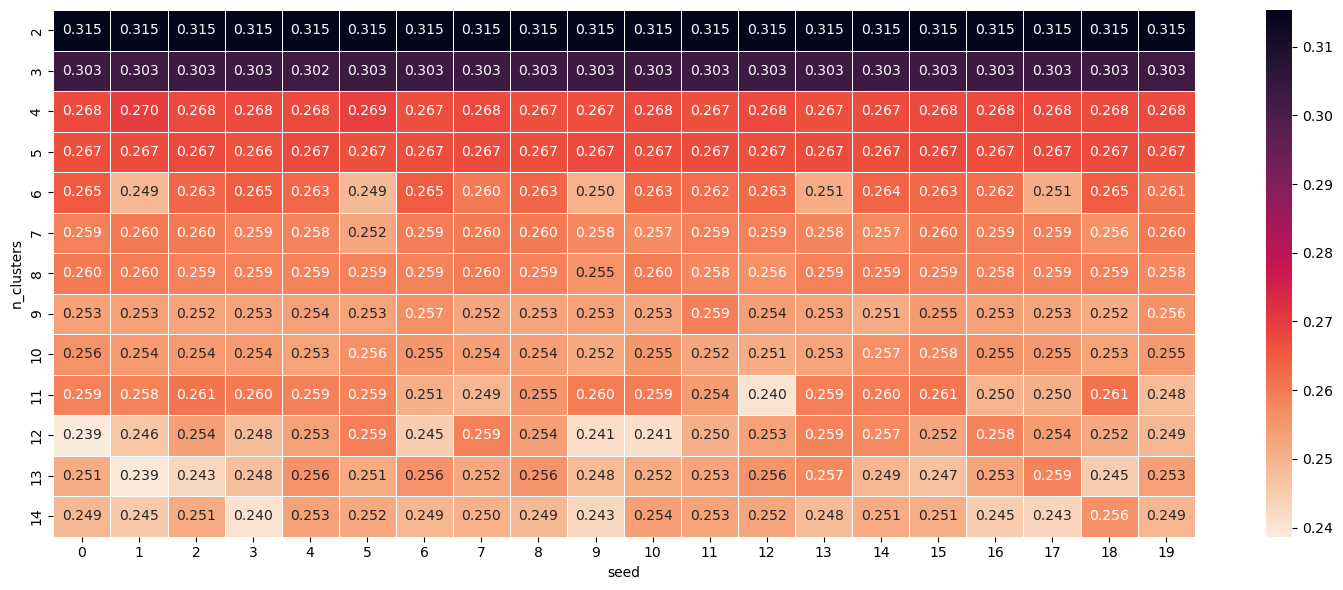

In [85]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.

chose 3 clusters to get more insight into data.

In [90]:
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

In [91]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Below I will create silhouette graph for 3 clusters in order to visually depict fit of each point within its own cluster (modified code from scikit-learn doc).

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


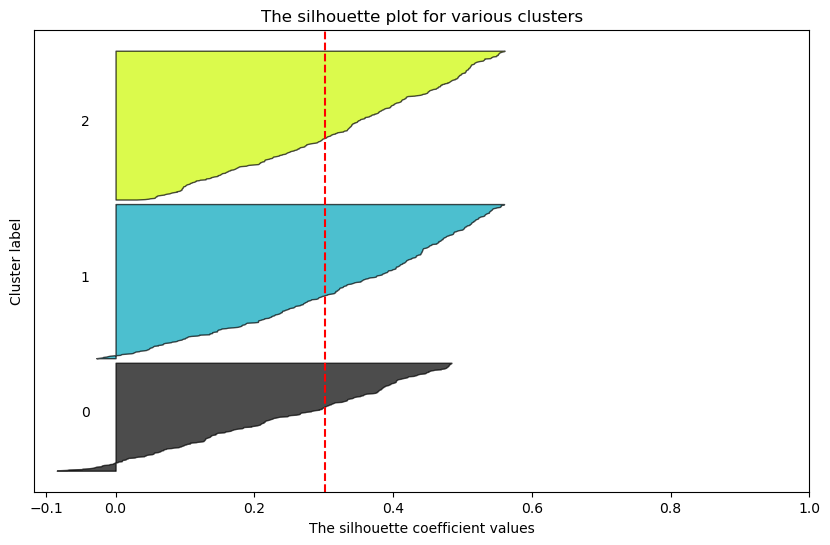

In [93]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


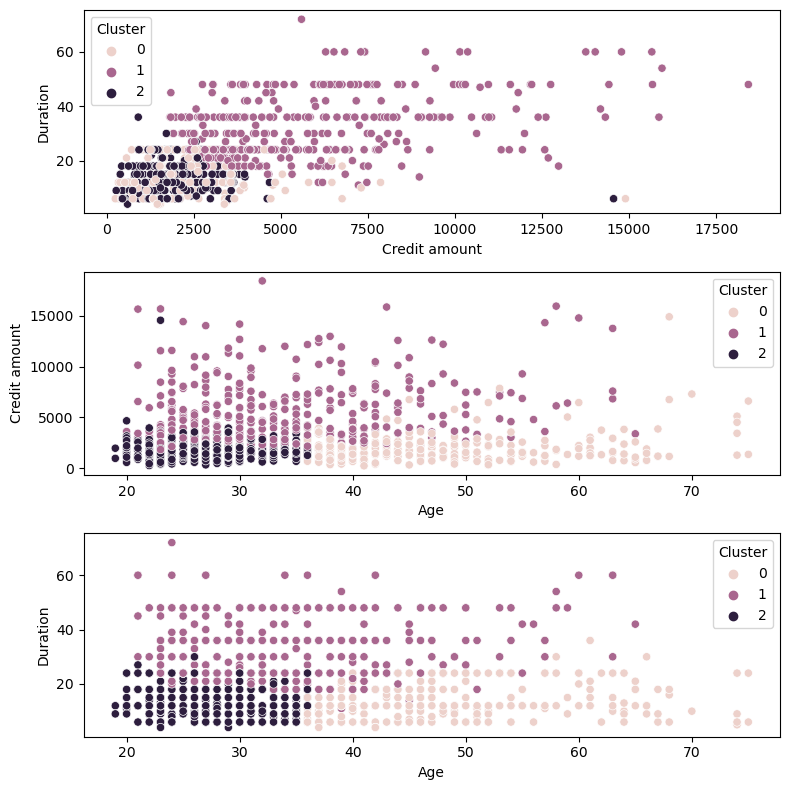

In [96]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

scatters(clustered_data, 'Cluster')

In [97]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


Cluster 0 – lower mean of credit amount, short duration, older customers

Cluster 1 – high mean of credit amount, long duration, middle-aged customers

Cluster 2 - lower mean of credit amount, short duration, young customers